In [4]:
# 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

In [5]:
# 2. Load Dataset
data = pd.read_csv('Churn_Modelling.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [6]:
# 3. Drop Irrelevant Columns
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [7]:
# 4. Encode categorical variables
label_encoder_gender = LabelEncoder()
data['Gender'] = label_encoder_gender.fit_transform(data['Gender'])

onehot_encoder_geo = OneHotEncoder()
geo_encoder = onehot_encoder_geo.fit_transform(data[['Geography']]).toarray()
geo_encoded_df = pd.DataFrame(
    geo_encoder,
    columns=onehot_encoder_geo.get_feature_names_out(['Geography'])
)

In [8]:
# 5. Combine encoded columns
data = pd.concat([data.drop('Geography', axis=1).reset_index(drop=True), geo_encoded_df], axis=1)
data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,1.0,0.0,0.0
1,608,0,41,1,83807.86,1,0,1,112542.58,0,0.0,0.0,1.0
2,502,0,42,8,159660.80,3,1,0,113931.57,1,1.0,0.0,0.0
3,699,0,39,1,0.00,2,0,0,93826.63,0,1.0,0.0,0.0
4,850,0,43,2,125510.82,1,1,1,79084.10,0,0.0,0.0,1.0


In [9]:
# 6. Save encoders
with open('label_encoder_gender.pkl', 'wb') as file:
    pickle.dump(label_encoder_gender, file)

with open('onehot_encoder_geo.pkl', 'wb') as file:
    pickle.dump(onehot_encoder_geo, file)

In [10]:
# 7. Define Features and Target
X = data.drop(['EstimatedSalary', 'Exited'], axis=1)
y = np.log1p(data['EstimatedSalary'])  # Log transform the target

print("Feature columns:", X.columns.tolist())

Feature columns: ['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Geography_France', 'Geography_Germany', 'Geography_Spain']


In [11]:
# 8. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# 9. Scale the Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
# 10. Save Scaler
with open('Salary_Scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

print("Scaler fitted on columns:", scaler.feature_names_in_)

Scaler fitted on columns: ['CreditScore' 'Gender' 'Age' 'Tenure' 'Balance' 'NumOfProducts'
 'HasCrCard' 'IsActiveMember' 'Geography_France' 'Geography_Germany'
 'Geography_Spain']


In [15]:
# 11. Build Regression Model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               1536      
                                                                 
 batch_normalization_2 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                      

In [16]:
# 12. Compile the Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mean_squared_error',
              metrics=['mae'])

In [17]:
# ✅ 13. Setup Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# ✅ 14. Train the Model
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=100,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
250/250 [==============================] - 6s 11ms/step - loss: 20.6274 - mae: 3.5352 - val_loss: 16.0043 - val_mae: 3.8621
Epoch 2/100
250/250 [==============================] - 3s 11ms/step - loss: 7.3068 - mae: 2.1669 - val_loss: 1.8963 - val_mae: 1.1702
Epoch 3/100
250/250 [==============================] - 2s 8ms/step - loss: 6.1054 - mae: 1.9819 - val_loss: 1.4624 - val_mae: 0.9683
Epoch 4/100
250/250 [==============================] - 2s 8ms/step - loss: 5.4480 - mae: 1.8643 - val_loss: 1.5129 - val_mae: 0.9951
Epoch 5/100
250/250 [==============================] - 2s 7ms/step - loss: 5.0805 - mae: 1.8037 - val_loss: 1.3672 - val_mae: 0.9369
Epoch 6/100
250/250 [==============================] - 2s 9ms/step - loss: 4.6125 - mae: 1.7143 - val_loss: 1.2137 - val_mae: 0.8533
Epoch 7/100
250/250 [==============================] - 2s 7ms/step - loss: 4.4088 - mae: 1.6740 - val_loss: 1.4095 - val_mae: 0.9635
Epoch 8/100
250/250 [==============================] - 2s 8ms/ste

In [18]:
# 15. Evaluate the Model
y_pred_log = model.predict(X_test_scaled)
y_pred = np.expm1(y_pred_log)  # Reverse log transformation
y_test_original = np.expm1(y_test)

mae = mean_absolute_error(y_test_original, y_pred)
mse = mean_squared_error(y_test_original, y_pred)
r2 = r2_score(y_test_original, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R^2 Score: {r2:.4f}")

63/63 [==============================] - 1s 8ms/step
Mean Absolute Error (MAE): 59038.01
Mean Squared Error (MSE): 5187898990.69
R^2 Score: -0.5715


In [19]:
# 16. Save the Model
model.save('model_salary.h5')



c:\Users\Shahzeena\anaconda3\envs\c12b2ann\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


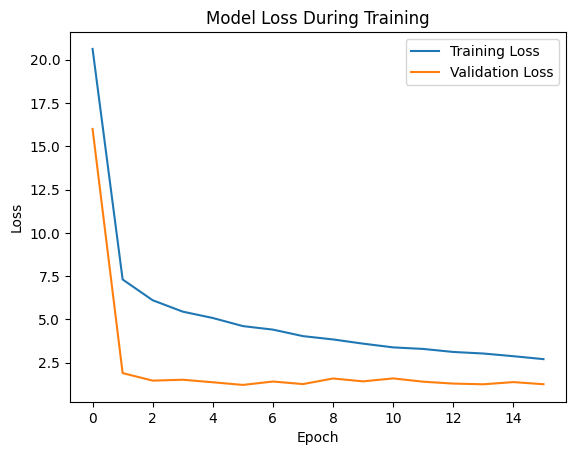

In [20]:
# 17. Plotting Loss Curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()